## Two layer neural network kernels and risk

This notebook contains the relevant code for the following figures in the paper "*Early stopping in deep networks: Double descent and how to eliminate it*":

- Figure 3

In [1]:
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pyplot as plt
from numpy import *
import numpy as np

### Linear model
The linear model generates sampels as

$$
y = \langle x,\beta \rangle + z,
$$

where $x \in \mathbb R^d$ is zero-mean Gaussian with diagonal co-variance matrix with diagonal $[\sigma_1^2,\ldots,\sigma_n^2]$, and $z$ is zero-mean Gaussian with variance $\sigma^2$.

In [2]:
class linear_model():
    def __init__(self,d,sigma_noise=0,beta=None,sigmas=None,normalized=True):
        self.d = d
        if beta is None:
            self.beta = np.random.randn(self.d)
            #self.beta = np.ones(self.d)
        else:
            self.beta = beta
        
        self.sigma_noise = sigma_noise
        
        if sigmas is None:
            if normalized:
                self.sigmas = np.ones(d) / np.sqrt(self.d)
            else:
                self.sigmas = np.ones(d)
        else:
            self.sigmas = sigmas
            
    def estimate_risk(self,estimator,avover=500):
        # estimator is an instance of a class with a predict function mapping x to a predicted y
        # function estimates the risk by averaging
        risk = 0
        for i in range(avover):
            x = np.random.randn(self.d) * self.sigmas 
            y = x @ self.beta + self.sigma_noise*np.random.randn(1)[0]
            risk += (y - estimator.predict(x))**2
        return risk/avover
    
    def compute_risk(self,hatbeta):
        # compute risk of a linear estimator based on formula
        return np.linalg.norm( self.beta - hatbeta )**2 + self.sigma_noise**2
    
    def sample(self,n):
        Xs = []
        ys = []
        for i in range(n):
            x = np.random.randn(self.d) * self.sigmas
            y = x @ self.beta + self.sigma_noise*np.random.randn(1)[0]
            Xs += [x]
            ys += [y]
        return np.array(Xs),np.array(ys)

# Two layer neural network model

We consider a two-layer neural network with ReLU non-linearities. The model is
$$
f(W,\theta) = \mathrm{relu}(W x) \theta \in \mathbb R,
$$
where $W \in \mathbb R^{m \times d}$ are the weights of the first layer, and $\theta \in \mathbb R^m$ are the weights in the second layer.

We consider the loss
$$
\sum_{i=1}^n  \frac{1}{2} ( f(W,\theta) - y_i )^2,
$$
which we optimize with respect to the weights $W$ and $\theta$ using gradient descent.

Note that 
$$
\frac{\partial L_i}{\partial w_j} 
=
( f(W,\theta) - y_i ) x_i a_j 1\{ w_j^T x_i >0 \}
$$
and
$$
\nabla_\theta L_i
=
\mathrm{relu}(W x) ( f(W,\theta) - y_i )
$$



# Kernel concentration

See if
$$
\sum_{i=1}^n
\frac{(1 - (1 - \eta \sigma^2_i)^k)^2}{\sigma_i^2}
(u_i^T y)^2
$$
concentrates. Here $H = U \Sigma U^T$ with
$$
H_{ij} 
=
\frac{1}{2}
\left(
1 - \cos^{-1} \left( \rho_{ij} \right) / \pi
\right)
x_i^T x_j.
$$

## Plotting the kernels

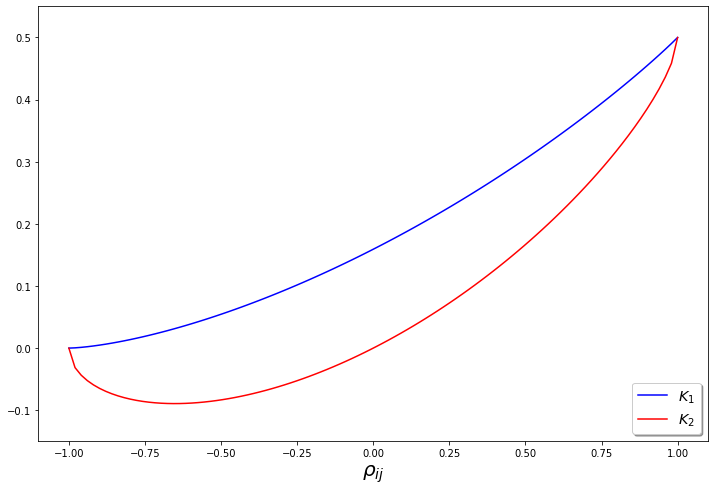

In [3]:
def dual_kernel_relu(rho):
    return 0.5*( np.sqrt(1 - (rho/1.0000001)**2)/pi + (1 - np.arccos(rho/1.0000001)/pi)*rho )

rhos = np.linspace(-1.0, 1.0, num=100)
kernel1 = [ 0.5*(1 - np.arccos(rho / 1.0000001 )/pi )*rho for rho in rhos ]
kernel2 = [ dual_kernel_relu(rho) for rho in rhos ]


fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)  
ax.plot(rhos,kernel2, color='blue', label=r'$K_1$')
ax.plot(rhos,kernel1, color='red', label=r'$K_2$')
ax.legend(loc=4, bbox_to_anchor=(1,0), fontsize='x-large',
          frameon=True, fancybox=True, shadow=True, ncol=1)
ax.set_xlabel(r'$\rho_{ij}$', fontsize=20)
ax.set_ylim([-0.15, 0.55])

plt.show()

# Combination of two kernels

Behaviour of the risk bound as a function on how the two kernels are combined.

In [4]:
d = 10
n = 10
model = linear_model(d,sigma_noise=0.00,normalized=False)
#model.beta = [-1.0,1.0]
print("model theta", model.beta)
Xs,ys = model.sample(n)
D = [(x,y) for x,y in zip(Xs,ys)]

# normalize
XsN = np.diag( 1/np.linalg.norm(Xs, axis = 1)) @ Xs
Rho = XsN @ XsN.T

# compute H1 - Gram matrix of kernel 1
H1 = 0.5*(1 - np.arccos((Rho) / 1.0000001 )/pi ) * (Xs @ Xs.T)

# compute H2 - Gram matrix of kernel 2
# def dual_kernel_relu(rho):
#     return 1/(2*pi) * ( np.sqrt(1- (rho/1.0000001)**2) + (pi - np.arccos(rho/1.0000001))*rho )

H2 = dual_kernel_relu(Rho) * np.outer( np.linalg.norm(Xs,axis=1) , np.linalg.norm(Xs,axis=1) )

#
U,S1,V = np.linalg.svd(H1)
print("H1: ", min(S1), max(S1))
#
U,S2,V = np.linalg.svd(H2)
print("H2: ", min(S2), max(S2))

model theta [ 1.0405646  -0.46422204  0.28378543 -1.31606291 -0.14081581 -0.8412353
  0.27209781  1.7156577  -1.94178472  2.37432319]
H1:  1.4500348848316078 12.156973731202147
H2:  0.5794376330933918 21.41408264488168


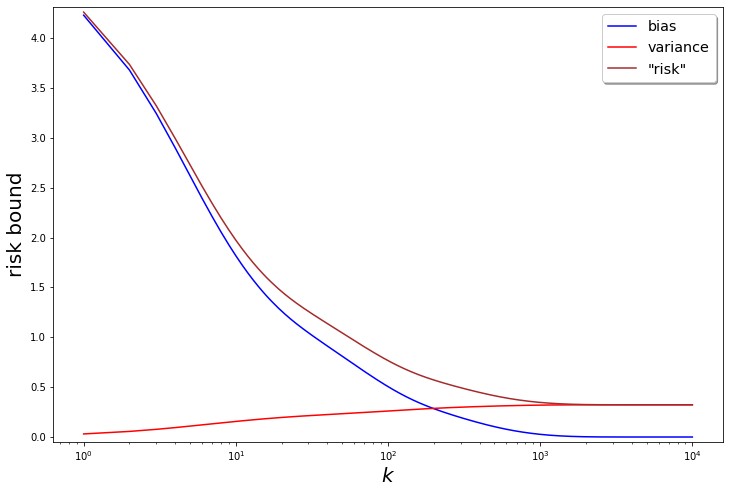

In [5]:
U,S,V = np.linalg.svd(1*H1+1*H2)
#random.shuffle(ys)

uys = np.array( [ ys.T @ u for u in U.T ] )
stepsize = 1/(2*max(S**2))

riskbound = []
kmax = 10000

part1 = np.array( [np.sqrt( 1/n * np.sum( uys**2*(1 - stepsize*(S**2))**(2*k) ) ) for k in range(1,kmax) ] )
part2 = np.array( [np.sqrt( 1/(2*n) * np.sum( uys**2*( 1 - (1 - stepsize*(S**2))**(k) )**2/S**2 ) ) for k in range(1,kmax) ] )


fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)  
ax.plot(range(1,kmax),part1, color='blue', label=r'bias')
ax.plot(range(1,kmax),part2, color='red', label=r'variance')
ax.plot(range(1,kmax),part1 + part2, color='brown', label=r'"risk"')
ax.legend(loc=1, bbox_to_anchor=(1,1), fontsize='x-large',
          frameon=True, fancybox=True, shadow=True, ncol=1)
ax.set_ylabel('risk bound', fontsize=20)
ax.set_xlabel(r'$k$', fontsize=20)
ax.set_xscale('log')
ax.set_ylim([-0.05, max([np.max(r) for r in [part1, part2, part1 + part2]]) + 0.05])

plt.show()